In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use("thesis")
from os.path import join
import seaborn as sns
from sys import path
path.insert(0,'../src/')
from glob import glob
from chemulator import Chemulator
import matplotlib.gridspec as gridspec
from time import perf_counter
import h5py
import tensorflow as tf

tf.compat.v1.disable_eager_execution()
from snapshot_functions import get_elemental_abundances


In [2]:
#constants
XH  = 0.76                        # the hydrogen mass fraction
gama= 5.0/3.0                     # the adiabatic index
KB  = 1.3807e-16                  # the Boltzmann constant in CGS units  [cm^2 g s^-2 K^-1]
KB_kev  = 8.6173324e-8 
mp  = 1.6726e-24                  # proton mass in CGS units
UnitMass_in_g = 1.989e43
UnitLength_in_cm    = 3.085678e21
PROTONMASS=1.6726e-24
UnitDensity_in_cgs = UnitMass_in_g / UnitLength_in_cm**3
UnitDensity_in_pccm = UnitDensity_in_cgs/PROTONMASS

# Prepare Input

Load the data that we processed in `data_explore.ipynb` and do a few final modifications. Start by making sure all abundances are set up and then making sure we only have the necessary columns. Then use `emulator.prepare_input` to prepare the data for the chemulator by scaling it.

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
autoencoder_dir="../autoencoders/noisy_8_encoder/"
emulator=Chemulator(autoencoder_dir)
emulator.load_model("../emulators/local-uv-test/")

In [5]:
# input_data=pd.read_hdf("../chemulator_input.hdf",key="df").reset_index(drop=True)
# filename = "/Users/raouf/Work_space/projects/ParticleGridMapper.jl/main_snap/CHIMES_1205_1e6/snapshot_060.hdf5"
filename = "/Users/raouf/Work_space/BH3V10B1_CH/snapshot_060.hdf5"
f = h5py.File(filename, "r")

In [6]:
f['PartType0']['Metallicity'].shape

(284408, 11)

In [7]:
f["PartType0"].keys()

<KeysViewHDF5 ['ArtificialViscosity', 'ChimesAbundances', 'ChimesColumnDensity', 'ChimesMu', 'CoolingRate', 'Coordinates', 'Density', 'HeatingRate', 'HydroHeatingRate', 'InternalEnergy', 'Masses', 'MetalCoolingRate', 'Metallicity', 'MolecularMassFraction', 'NetHeatingRateQ', 'ParticleChildIDsNumber', 'ParticleIDGenerationNumber', 'ParticleIDs', 'SmoothingLength', 'StarFormationRate', 'TimeStep', 'Velocities']>

In [8]:
input_data=get_elemental_abundances(f["PartType0"]["ChimesAbundances"])

In [9]:
input_data

,H,D,He,C,N,O,F,P,S,Cl,Li,Na,Mg,Ca,Si,PAH,15N,13C,18O,E-
0,1.0,0.0,0.1,0.000268,0.000263,0.000464,8.650412e-07,0.0,0.000011,0.0,0.0,0.0,0.000008,0.000004,0.000007,0.0,0.0,0.0,0.0,0.063678
1,1.0,0.0,0.1,0.000270,0.000263,0.000467,8.576734e-07,0.0,0.000011,0.0,0.0,0.0,0.000008,0.000004,0.000007,0.0,0.0,0.0,0.0,0.062927
2,1.0,0.0,0.1,0.000272,0.000263,0.000472,1.051239e-06,0.0,0.000011,0.0,0.0,0.0,0.000009,0.000004,0.000008,0.0,0.0,0.0,0.0,0.082835
3,1.0,0.0,0.1,0.000272,0.000263,0.000472,1.078713e-06,0.0,0.000012,0.0,0.0,0.0,0.000009,0.000004,0.000008,0.0,0.0,0.0,0.0,0.082313
4,1.0,0.0,0.1,0.000280,0.000263,0.000484,1.369873e-06,0.0,0.000012,0.0,0.0,0.0,0.000010,0.000004,0.000009,0.0,0.0,0.0,0.0,0.250436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284403,1.0,0.0,0.1,0.000238,0.000263,0.000412,3.211885e-07,0.0,0.000009,0.0,0.0,0.0,0.000005,0.000004,0.000004,0.0,0.0,0.0,0.0,0.000082
284404,1.0,0.0,0.1,0.000238,0.000263,0.000412,3.211885e-07,0.0,0.000009,0.0,0.0,0.0,0.000005,0.000004,0.000004,0.0,0.0,0.0,0.0,0.000037
284405,1.0,0.0,0.1,0.000238,0.000263,0.000412,3.211885e-07,0.0,0.000009,0.0,0.0,0.0,0.000005,0.000004,0.000004,0.0,0.0,0.0,0.0,0.000057
284406,1.0,0.0,0.1,0.000238,0.000263,0.000412,3.211925e-07,0.0,0.000009,0.0,0.0,0.0,0.000005,0.000004,0.000004,0.0,0.0,0.0,0.0,0.000042


In [30]:
mu  = (4.*mp)/(1.+3.*XH+4.*XH*input_data["E-"]) # mean Molecular weight
input_data["mu"] = mu
# input_data=pd.DataFrame()
input_data["gas_temp"] = f['PartType0']['InternalEnergy'][()]
input_data["gas_temp"] = (gama-1)* (input_data["gas_temp"]/KB)* mu* 1e10 # K

input_data["gas_density"]=f["PartType0"]["Density"][()] * UnitDensity_in_pccm
input_data["gas_density"].div(mu)

input_data["zeta"]=10.0 # I assume also CRIR is milky way
input_data["coldens"]=f["PartType0"]["ChimesColumnDensity"][()]
input_data["Av"]=input_data["coldens"]*1.6e-21

input_data["local_radfield"]=1.0 #Mojtaba says he's using Milky way ISRF
input_data["local_radfield"]=input_data["local_radfield"]*np.exp(-3.02*input_data["Av"])
input_data["local_radfield"]=np.where(input_data["local_radfield"]<1e-10,1e-10,input_data["local_radfield"])#put a lower limit on that


# for element,abundance in elemental_abundances.items():
#     input_data[element]=abundance
# input_data["metallicity"]= input_data["C"]/ 2.64e-4
input_data["metallicity"] = (f['PartType0']['Metallicity'][:,0]+
                             f['PartType0']['Metallicity'][:,1]+
                             f['PartType0']['Metallicity'][:,2]+
                             f['PartType0']['Metallicity'][:,3]+
                             f['PartType0']['Metallicity'][:,4]+
                             f['PartType0']['Metallicity'][:,5]+
                             f['PartType0']['Metallicity'][:,6]+
                             f['PartType0']['Metallicity'][:,7]+
                             f['PartType0']['Metallicity'][:,8]+
                             f['PartType0']['Metallicity'][:,9]+
                             f['PartType0']['Metallicity'][:,10])/11

# chem_1-8
input_data["CO"]=f["PartType0"]["ChimesAbundances"][:,148]
input_data["H2"]=f["PartType0"]["ChimesAbundances"][:,137]
# input_data["XHI"]=f["PartType0"]["ChimesAbundances"][:,1]
# input_data["XCI"]=f["PartType0"]["ChimesAbundances"][:,7]


In [31]:
np.log10(input_data["gas_density"]).max()

6.171836418542844

/opt/homebrew/Caskroom/miniconda/base/envs/mlp/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


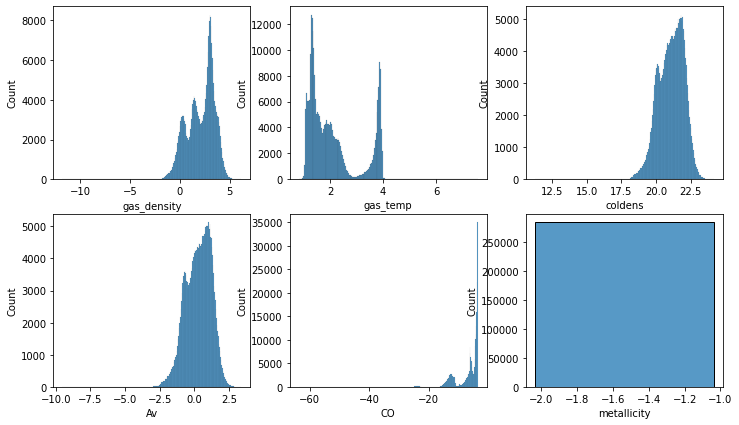

In [32]:
fig,axes=plt.subplots(2,3,figsize=(12,7))
axes=axes.flatten()

for i,variable in enumerate(["gas_density","gas_temp","coldens","Av","CO","metallicity"]):
    sns.histplot(np.log10(input_data[variable]),ax=axes[i])


In [33]:

input_data_test=pd.DataFrame()
input_data_test["C"]= f["PartType0"]["ChimesAbundances"][:,7]+f["PartType0"]["ChimesAbundances"][:,8]+f["PartType0"]["ChimesAbundances"][:,9]+f["PartType0"]["ChimesAbundances"][:,10]+f["PartType0"]["ChimesAbundances"][:,11]+f["PartType0"]["ChimesAbundances"][:,12]+f["PartType0"]["ChimesAbundances"][:,13]+f["PartType0"]["ChimesAbundances"][:,14]
input_data_test["E-"]= f["PartType0"]["ChimesAbundances"][:,0]
input_data_test["mu"]= f["PartType0"]["ChimesMu"][()]

Text(0.5, 0, 'C_test')

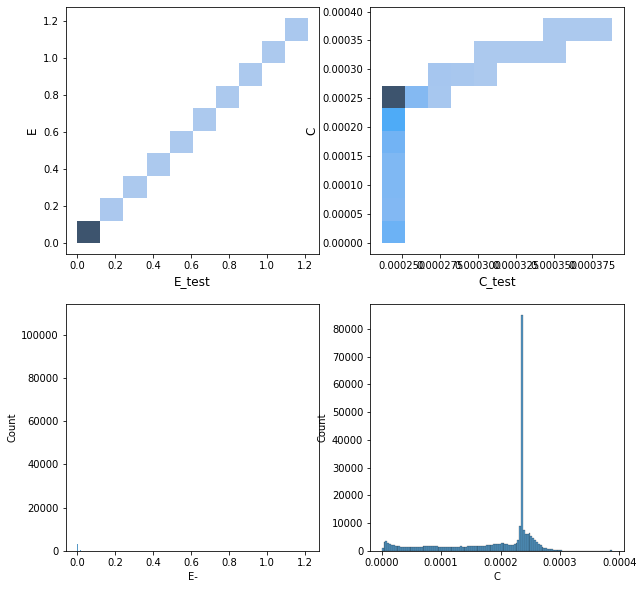

In [34]:
fig,axes=plt.subplots(2,2,figsize=(10,10))
axes=axes.flatten()
for i,variable in enumerate(["E-","C"]):
    g = sns.histplot(x=(input_data[variable]),y=(input_data_test[variable]), ax = axes[i],bins = 10)

sns.histplot((input_data["E-"]),ax=axes[2])
sns.histplot((input_data_test["C"]),ax=axes[3])
# axes[0].set(xlim=(-20,-5),ylim=(-20,-5)) 
axes[0].set_ylabel("E" , size = 12 )
axes[0].set_xlabel( "E_test" , size = 12)
# axes[1].set(xlim=(-10,3),ylim=(-10,3))
axes[1].set_ylabel("C" , size = 12 )
axes[1].set_xlabel( "C_test" , size = 12)



In [35]:
for species in emulator.autoencoder.species:
    if species not in input_data.columns:
        input_data[species]=0.0
input_data=input_data[emulator.physics_labels+list(emulator.autoencoder.species)]

In [36]:
input_data=emulator.prepare_inputs(input_data,learn_scaling=False)


/Users/raouf/Dropbox/Leiden Observatory/Chemulator/Gizmo_Chemulator/Notebooks/../src/chemulator.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data["metallicity"]=(input_data[self.species].values*self.c_idxs).sum(axis=1)
/Users/raouf/Dropbox/Leiden Observatory/Chemulator/Gizmo_Chemulator/Notebooks/../src/chemulator.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data["metallicity"]=input_data["metallicity"]/2.6e-4
/opt/homebrew/Caskroom/miniconda/base/envs/mlp/lib/python3.8/site-pac

In [37]:
input_data

,gas_temp,gas_density,local_radfield,zeta,metallicity,Chem_1,Chem_2,Chem_3,Chem_4,Chem_5,Chem_6,Chem_7,Chem_8
0,0.914975,0.000000,0.495085,0.5,0.805325,0.888490,0.400565,0.019737,0.001363,0.236753,6.142954e-02,1.0,0.037133
1,0.909106,0.000000,0.493508,0.5,0.806269,0.888737,0.400584,0.019721,0.001362,0.234669,6.142845e-02,1.0,0.037121
2,0.920424,0.000000,0.496467,0.5,0.808145,0.870820,0.399413,0.021094,0.001405,0.633623,6.439549e-02,1.0,0.038392
3,0.923159,0.000000,0.497063,0.5,0.808096,0.866841,0.399151,0.021361,0.001414,0.739352,6.494386e-02,1.0,0.038664
4,0.927114,0.000000,0.498313,0.5,0.812639,0.842256,0.397781,0.023827,0.001454,1.000000,6.868329e-02,1.0,0.039493
...,...,...,...,...,...,...,...,...,...,...,...,...,...
284403,0.311474,0.304416,0.204522,0.5,0.901638,0.998989,0.408771,0.004369,0.000687,0.993945,1.437125e-06,1.0,0.004678
284404,0.268157,0.346460,0.000000,0.5,0.901727,0.999067,0.408781,0.004543,0.000675,0.993911,4.990016e-08,1.0,0.004237
284405,0.277713,0.318355,0.049272,0.5,0.903162,0.999064,0.408780,0.004503,0.000677,0.993950,1.297404e-07,1.0,0.004296
284406,0.176398,0.359543,0.000000,0.5,0.887344,0.999060,0.408786,0.004887,0.000663,0.993494,2.764469e-05,1.0,0.003805


In [38]:
input_data["metallicity"][input_data["metallicity"] > 0]

0         0.805325
1         0.806269
2         0.808145
3         0.808096
4         0.812639
            ...   
284403    0.901638
284404    0.901727
284405    0.903162
284406    0.887344
284407    0.786383
Name: metallicity, Length: 284408, dtype: float64

# Make Predictions

Chemulator advances the chemistry by 1000 years each time it is called. So let's call it 1000 times to get the predictions for the next 1 Myr.

In [39]:
start=perf_counter()
nsteps=10
predict=emulator.predict_multiple_timesteps(input_data.copy(),nsteps)
end=perf_counter()
end=(end-start)/60.0
print(f"{nsteps} steps in {end} minutes")

/opt/homebrew/Caskroom/miniconda/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


10 steps in 3.491334411800002 minutes


In [41]:
unscaled_predict=emulator.recover_real_values(predict)

/opt/homebrew/Caskroom/miniconda/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [42]:
unscaled_predict

,gas_temp,dust_temp,H,H+,H2,H2+,H3+,HE,HE+,C+,...,H2O,H3O+,MG,MG+,CO+,CO,HCO+,O2,O2+,E-
0,682.552501,15.286006,1.000000,1.214699e-04,0.000176,1.609736e-13,9.185329e-15,0.121635,1.483998e-07,0.000008,...,2.919633e-13,6.002771e-13,2.711481e-11,0.000011,1.519337e-14,4.631441e-07,1.317203e-11,5.071677e-15,1.221059e-11,0.000141
1,683.121464,14.579763,1.000000,1.017834e-04,0.000331,2.007353e-13,2.737620e-14,0.119972,1.023058e-07,0.000009,...,1.143477e-12,2.000154e-12,2.687686e-11,0.000009,2.310062e-14,2.920607e-07,9.810661e-12,9.213651e-15,1.772327e-11,0.000120
2,990.583639,16.689766,1.000000,1.948565e-04,0.000016,7.563423e-14,2.752612e-16,0.120821,2.894824e-07,0.000011,...,5.359992e-15,1.446144e-14,2.842179e-11,0.000017,8.055272e-15,2.680171e-07,1.170637e-10,2.179625e-15,4.908302e-12,0.000223
3,1133.976042,16.889322,1.000000,2.056223e-04,0.000008,6.522184e-14,1.391075e-16,0.119554,2.749531e-07,0.000011,...,2.443433e-15,6.789364e-15,2.712201e-11,0.000019,7.462720e-15,2.209396e-07,2.761323e-10,2.131212e-15,4.411784e-12,0.000236
4,1703.781243,16.454936,1.000000,2.181852e-04,0.000003,5.288638e-14,1.178729e-16,0.117618,1.139459e-07,0.000008,...,1.675966e-15,4.017909e-15,1.210413e-11,0.000015,8.355515e-15,7.852158e-07,1.482103e-09,4.728118e-15,8.851361e-12,0.000241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284403,93.912321,15.034715,0.212267,1.733889e-06,0.196299,5.976203e-12,4.478234e-10,0.108939,1.241205e-08,0.000028,...,1.022970e-09,1.163193e-10,5.963854e-09,0.000009,1.981309e-13,8.277917e-04,3.274517e-11,1.164264e-11,2.126023e-13,0.000038
284404,88.571194,20.781249,0.102214,8.525435e-07,0.236857,3.777278e-12,5.233048e-10,0.108946,6.265766e-09,0.000013,...,5.490015e-10,6.333369e-11,3.996948e-09,0.000006,5.400848e-14,7.525104e-04,2.034994e-11,6.392626e-12,8.547122e-14,0.000020
284405,91.026436,18.431062,0.111649,1.140263e-06,0.241459,5.433024e-12,7.285033e-10,0.108769,9.461786e-09,0.000015,...,7.418067e-10,9.013987e-11,3.745388e-09,0.000006,8.031005e-14,6.661707e-04,2.782768e-11,7.689373e-12,1.221778e-13,0.000022
284406,79.464876,20.379272,0.133816,9.704939e-07,0.209305,3.756961e-12,3.436804e-10,0.109291,6.512152e-09,0.000017,...,4.564371e-10,4.277155e-11,6.524719e-09,0.000008,6.318145e-14,1.069340e-03,1.293726e-11,6.677891e-12,6.814038e-14,0.000026


In [46]:
snap = 60
filename_w = '/Users/raouf/Work_space/BH3V10B1_CH/Chemulator_snap_%03d.hdf5' % snap
fw = h5py.File(filename_w, "w")
label = ["gas_temp","dust_temp","H","H+","H2","H2+","H3+","HE","HE+","C+","C","CH","CH+","CH2","CH2+","CH3+","CH3","CH4+","O+","CH4","O","CH5+","OH+","OH","H2O+","H2O","H3O+","MG","MG+","CO+","CO","HCO+","O2","O2+","E-"]

for i,variable in enumerate(label):
    fw.create_dataset(variable,data=unscaled_predict[variable],chunks = True)
#fw  = h5py.File("Pr_snap_60.hdf5", "r")

In [47]:
prediction  = h5py.File(filename_w, "r")

In [48]:
# prediction["CO"][()]

In [49]:
prediction.keys()

<KeysViewHDF5 ['C', 'C+', 'CH', 'CH+', 'CH2', 'CH2+', 'CH3', 'CH3+', 'CH4', 'CH4+', 'CH5+', 'CO', 'CO+', 'E-', 'H', 'H+', 'H2', 'H2+', 'H2O', 'H2O+', 'H3+', 'H3O+', 'HCO+', 'HE', 'HE+', 'MG', 'MG+', 'O', 'O+', 'O2', 'O2+', 'OH', 'OH+', 'dust_temp', 'gas_temp']>

In [50]:
# fig,axes=plt.subplots(2,2,figsize=(10,10))
# axes=axes.flatten()
# # for i,variable in enumerate(["gas_temp","dust_temp","CO","H2"]):
# #     sns.histplot(np.log10(prediction[variable][()]),ax=axes[i])
    
# for i,variable in enumerate(["gas_temp","CO","H2"]):
#     g = sns.histplot(x=np.log10(input_data[variable]),y=np.log10(prediction[variable][()]), ax = axes[i])
#     g.axes.axline((0,0), slope=1.0, c=".2", ls="--", zorder=0.)
    

In [51]:
filename = "/Users/raouf/Work_space/BH3V10B1_CH/snapshot_060_eqm_1e6.hdf5"
f2 = h5py.File(filename, "r")

In [52]:
f2.keys()

<KeysViewHDF5 ['EqmChemistryAbundances']>

In [53]:
#input_data_eqm=get_elemental_abundances(f2["EqmChemistryAbundances"])

In [54]:
input_data_eqm=pd.DataFrame()
# input_data_eqm

In [55]:
input_data_eqm["CO"]=f2["EqmChemistryAbundances"][:,148]
input_data_eqm["H2"]=f2["EqmChemistryAbundances"][:,137]

# input_data_eqm["CO_Chem"]=unscaled_predict["CO"]
# input_data_eqm["H2_Chem"]=unscaled_predict["H2"]

/opt/homebrew/Caskroom/miniconda/base/envs/mlp/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/mlp/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[(-10.0, 0.0), (0.0, 40000.0)]

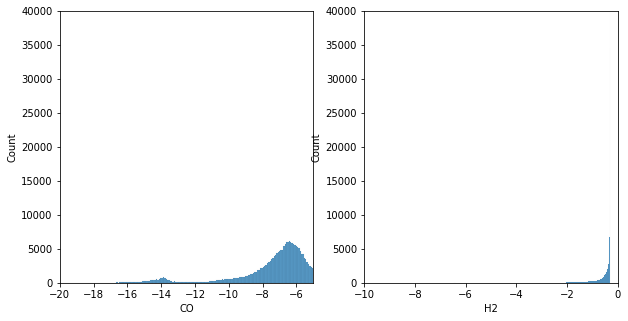

In [56]:
fig,axes=plt.subplots(1,2,figsize=(10,5))
axes=axes.flatten()
for i,variable in enumerate(["CO","H2"]):
    sns.histplot(np.log10(input_data_eqm[variable]),ax=axes[i])
axes[0].set(xlim=(-20,-5),ylim=(0,40000))
axes[1].set(xlim=(-10,0),ylim=(0,40000))
# axes[2].set(xlim=(-20,-5),ylim=(0,70000))
# axes[3].set(xlim=(-10,0),ylim=(0,70000))

/opt/homebrew/Caskroom/miniconda/base/envs/mlp/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'H2 (CHIMES)')

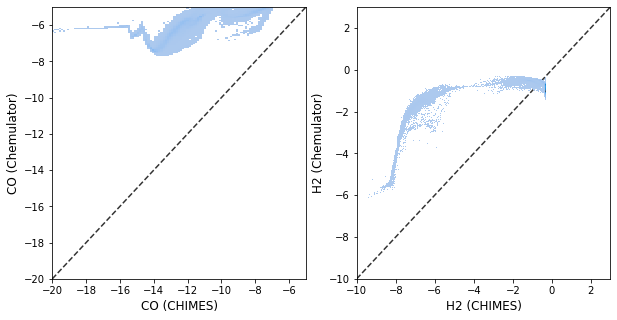

In [58]:
input_data["CO"]=f["PartType0"]["ChimesAbundances"][:,148] # Non-Eq
input_data["H2"]=f["PartType0"]["ChimesAbundances"][:,137] # Non-Eq

fig,axes=plt.subplots(1,2,figsize=(10,5))
axes=axes.flatten()
for i,variable in enumerate(["CO","H2"]):
    g = sns.histplot(x=np.log10(input_data[variable]),y=np.log10(prediction[variable][()]), ax = axes[i])
    g.axes.axline((-60,-60), slope=1.0, c=".2", ls="--", zorder=0.)

axes[0].set(xlim=(-20,-5),ylim=(-20,-5)) 
axes[0].set_ylabel("CO (Chemulator)" , size = 12 )
axes[0].set_xlabel( "CO (CHIMES)" , size = 12)
axes[1].set(xlim=(-10,3),ylim=(-10,3))
axes[1].set_ylabel("H2 (Chemulator)" , size = 12 )
axes[1].set_xlabel( "H2 (CHIMES)" , size = 12)

# savename = './plots/Prediction_CHIMES_snap_%03d.pdf' % snap
# plt.savefig(savename)


In [40]:
# fig,axes=plt.subplots(1,2,figsize=(10,5))
# axes=axes.flatten()
# for i,variable in enumerate(["CO","H2"]):
#     g = sns.histplot(x=np.log10(input_data_eqm[variable]),y=np.log10(input_data[variable]), ax = axes[i])
#     g.axes.axline((-60,-60), slope=1.0, c=".2", ls="--", zorder=0.)

# axes[0].set(xlim=(-20,-5),ylim=(-20,-5)) 
# axes[0].set_ylabel("CO (CHIMES-Non-Eqm)" , size = 12 )
# axes[0].set_xlabel( "CO (CHIMES-Eqm)" , size = 12)
# axes[1].set(xlim=(-10,3),ylim=(-10,3))
# axes[1].set_ylabel("H2 (CHIMES-Non-Eqm)" , size = 12 )
# axes[1].set_xlabel( "H2 (CHIMES-EQM)" , size = 12)
